In [1]:
from lsst.daf.butler import Butler

In [2]:
butler = Butler('dp02', collections=["u/ameisner/custom_coadd_window1_test1"])

my_dataId = {'band': 'i', 'tract': 4431, 'patch': 17}
my_deepCoadd = butler.get('deepCoadd', my_dataId)
my_deepCoadd_photoCalib = my_deepCoadd.getPhotoCalib()

In [3]:
del butler

In [4]:
butler = Butler('dp02', collections=["u/ameisner/custom_coadd_window1_test1_det"])

In [5]:
my_sources = butler.get('deepCoadd_meas', dataId=my_dataId)

In [6]:
# this is will be in the ~5-6k sources range (higher than expected) because it's necessary to trim to 
# detect_isPrimary=True

len(my_sources)

5603

In [7]:
my_sources = my_sources[my_sources['detect_isPrimary'] == True]

In [8]:
# now this very closely matches the original version of notebook 9b to within a few sources

len(my_sources)

2673

In [9]:
my_sources["base_PsfFlux_instFlux"]

array([ 28.58142319,  23.09514315,  22.42529654, ...,  19.51812599,
       218.58003285,  36.09596809])

In [10]:
# mostly copied from original version of notebook 9b

import numpy as np

i_CalibMag_AB = np.zeros(len(my_sources), dtype='float')
for s in range(len(my_sources)):
    i_CalibMag_AB[s] = \
    my_deepCoadd_photoCalib.instFluxToMagnitude(my_sources['base_PsfFlux_instFlux'][s])

In [11]:
i_CalibMag_AB


array([23.35979037, 23.59119835, 23.62315451, ..., 23.77390471,
       21.15097378, 23.10635326])

In [12]:
len(i_CalibMag_AB)

2673

(array([  9.,   9.,  13.,  32., 111.,  85., 101., 144., 291., 551., 917.,
        394.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([15.58436506, 16.31208338, 17.03980171, 17.76752004, 18.49523837,
        19.22295669, 19.95067502, 20.67839335, 21.40611167, 22.13383   ,
        22.86154833, 23.58926665, 24.31698498, 25.04470331, 25.77242164,
        26.50013996, 27.22785829, 27.95557662, 28.68329494, 29.41101327,
        30.1387316 ]),
 [<matplotlib.patches.Polygon at 0x7f7a301fdb70>])

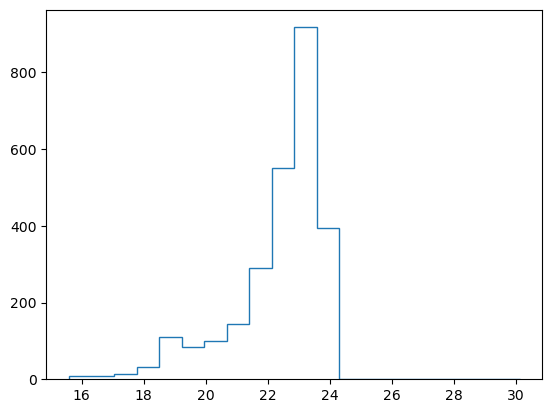

In [19]:
import matplotlib.pyplot as plt
plt.hist(i_CalibMag_AB, bins=20, histtype='step', label='custom coadd')


In [16]:
from lsst.rsp import get_tap_service, retrieve_query
tap_service = get_tap_service()

In [17]:
%%time
query = "SELECT objectId, coord_ra, coord_dec, detect_isPrimary, " + \
        "scisql_nanojanskyToAbMag(i_calibFlux) AS i_calibMag, " + \
        "scisql_nanojanskyToAbMagSigma(i_calibFlux, i_calibFluxErr) AS i_calibMagErr, " + \
        "i_extendedness " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', 55.757, -32.295, 0.2)) = 1 " + \
        "AND i_calibFlux/i_calibFluxErr >= 10 " + \
        "AND detect_isPrimary = 1"

tap_results = tap_service.search(query)
tap_table = tap_results.to_table().to_pandas()

CPU times: user 355 ms, sys: 4.97 ms, total: 360 ms
Wall time: 5.59 s


In [18]:
len(tap_table)

13297

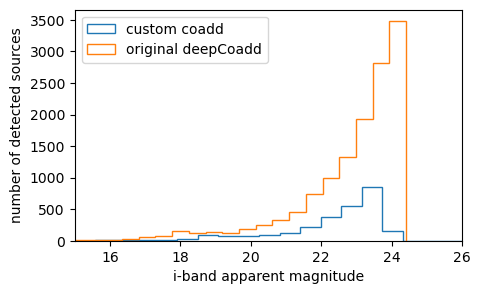

In [25]:

plt.figure(figsize=(5, 3))

plt.hist(i_CalibMag_AB, bins=25, histtype='step', label='custom coadd')
plt.hist(tap_table['i_calibMag'], bins=20, histtype='step', label='original deepCoadd')

plt.xlabel('i-band apparent magnitude')
plt.ylabel('number of detected sources')
plt.legend(loc='upper left')
plt.xlim([15, 26])
plt.show()